In [32]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from preproc import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

In [33]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [34]:
# Save directory for figures and data files
figsave_dir = f'figures/{day_dir}/sigcells'
datasave_dir = f'data/sigcells'

### Preprocessing of rplparallel, spiketrain, vmpv, raycast data

In [35]:
# Get list of cells under the day directory
cell_list = list()
with open(f"sigcells/{day_dir}.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp_file = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp_file.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.round(np.array(rp.get('timeStamps')), 3)
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)
rp_file.close()

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    try:
        spk_file = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except NotImplementedError:
        spk_file = h5py.File(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    except FileNotFoundError:
        continue
    spk = np.array(spk_file.get('timestamps')).flatten() # spike timestamps is loaded in as a column vector
    spk /= 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    if isinstance(spk_file, h5py.File):
        spk_file.close()
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv_file = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv_file.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)
pv_file.close()

# Load data from binData.hdf object, extract view bin data
viewbin_data = np.genfromtxt(prefix + day_dir + "/session01/1binData.csv", delimiter=',')
viewbin_data[:,0] /= 1000 # convert eyelink timestamps from msec to sec

In [36]:
# Define important constants
num_cells = len(cell_labels)
num_goals = 6
tbin_size = 0.001

In [37]:
# Get trial outcomes from trial markers
# 0 for unsuccessful trials, 1 for successful trials
trial_outcomes = 4 - trial_markers[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)

# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

# Further differentiate trial markers into trial trajectories (start poster, end poster)
trial_trajectories = np.zeros((trial_markers.shape[0], 2))
trial_trajectories[:,1] = trial_markers
trial_trajectories[1:,0] = trial_markers[:-1]

In [38]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_outcomes = trial_outcomes[trial_filt]
trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt]
nav_intervals = nav_intervals[trial_filt]
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]
trial_trajectories = trial_trajectories[trial_filt]

Cue phase data

In [39]:
# Extract periods in cue phase where cue image was not looked at
# Preallocate list of arrays for spike counts per time bin in cue phase
cueimg_filter = list()
timebins_cue = list()
spikecounts_cue = list()
for trial in cue_intervals:
    st_time, ed_time = trial
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    cueimg_filter.append(viewbin_data_trial[:,1] == 1)
    timebins_cue.append(np.hstack([viewbin_data_trial[:,0].reshape(-1,1), viewbin_data_trial[:,0].reshape(-1,1)+tbin_size]))
    spikecounts_cue.append(np.zeros((viewbin_data_trial.shape[0], num_cells)))

# Slot spikes into cue phase intervals, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
# Also filter out time bins where cue image was not looked at
for i, trial in enumerate(timebins_cue):
    spikecounts_cue[i] = np.array(spike_counts_per_observation(trial, spike_times))
    spikecounts_cue[i] = spikecounts_cue[i][cueimg_filter[i]]

# Convert spike counts to average spike rates across duration of cue phase
spikerates_cue = np.empty((len(spikecounts_cue), num_cells))
spikerates_cue[:,:] = np.nan
for i, trial in enumerate(spikecounts_cue):
    if timebins_cue[i].shape[0] > 0:
        spikerates_cue[i,:] = np.sum(trial, axis=0)/(tbin_size*timebins_cue[i].shape[0])

# Filter out trials with nans in cue spike rates
goals_cue = trial_markers.copy()
trajectories_cue = trial_trajectories.copy()
cue_filter = np.all(~np.isnan(spikerates_cue),axis=1)
spikerates_cue = spikerates_cue[cue_filter,:]
goals_cue = goals_cue[cue_filter]
trajectories_cue = trajectories_cue[cue_filter]


Hint viewing data

In [40]:
# Grab periods in the navigation phase when the hint image was looked at
# As well as which goal it corresponded to
def chunk_into_intervals(timepts: np.array, tbin: float=0.001) -> np.array:
    intervals = list()
    i, st = 0, None
    while i < timepts.shape[0]:
        curr = timepts[i]
        if st is None:
            st = curr
        elif curr > prev + 1.1 * tbin:
            intervals.append(np.array([st, prev+tbin]))
            st = curr
        prev = curr
        i += 1
    if st is not None:
        intervals.append(np.array([st, prev+tbin]))
    return np.array(intervals)

timebins_hints = list()
spikecounts_hints = list()
for trial in nav_intervals:
    st_time, ed_time = trial
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    hint_periods_trial = chunk_into_intervals(viewbin_data_trial[viewbin_data_trial[:,1] == 2, 0])
    timebins_hints.append(hint_periods_trial)
    spikecounts_hints.append(np.zeros((hint_periods_trial.shape[0], num_cells)))

# Slot spikes into hint viewing periods
for i, trial in enumerate(timebins_hints):
    spikecounts_hints[i] = np.array(spike_counts_per_observation(trial, spike_times))

'''
# Convert spike counts into spike rates per instance of hint viewing
spikerates_hints = list()
for i, trial in enumerate(spikecounts_hints):
    trial_spikerates = np.empty((len(trial), num_cells))
    trial_spikerates[:,:] = np.nan
    if timebins_hints[i].shape[0] > 0:
        trial_spikerates = trial/(timebins_hints[i][:,1]-timebins_hints[i][:,0])[:,np.newaxis]
    spikerates_hints.append(trial_spikerates)
'''

# Convert spike counts to average spike rates across all hint viewing instances per trial
spikerates_hints = np.empty((len(spikecounts_hints), num_cells))
spikerates_hints[:,:] = np.nan
for i, trial in enumerate(spikecounts_hints):
    if timebins_hints[i].shape[0] > 0:
        spikerates_hints[i,:] = np.sum(trial, axis=0)/np.sum(timebins_cue[i][:,1]-timebins_cue[i][:,0])

'''
# Flatten hint spike rates into a single long array containing all instances across trials
goals_hints = list()
for i, goal in enumerate(trial_markers):
    goals_hints.extend(spikerates_hints[i].shape[0]*[goal])
goals_hints = np.array(goals_hints)
trajectories_hints = list()
for i, traj in enumerate(trial_trajectories):
    trajectories_hints.extend([traj for _ in range(spikerates_hints[i].shape[0])])
trajectories_hints = np.array(trajectories_hints)
spikerates_hints = np.vstack(spikerates_hints)
'''
goals_hints = trial_markers.copy()
trajectories_hints = trial_trajectories.copy()

# Filter out trials with nans in hint spike rates
hints_filter = np.all(~np.isnan(spikerates_hints),axis=1)
spikerates_hints = spikerates_hints[hints_filter,:]
goals_hints = goals_hints[hints_filter]
trajectories_hints = trajectories_hints[hints_filter]

In [41]:
hint_viewing_occurences = list(map(lambda arr: arr.shape[0], timebins_hints))

Navigation end (last second) data

In [42]:
# View bins for all of the posters on the pillar walls
poster_viewbins = np.concatenate([np.arange(4533,4536+1), np.arange(4565,4568+1), np.arange(4597,4600+1), np.arange(4685,4688+1), np.arange(4717,4720+1), np.arange(4749,4752+1),\
                                    np.arange(4701,4704+1), np.arange(4733,4736+1), np.arange(4765,4768+1), np.arange(4845,4848+1), np.arange(4877,4480+1), np.arange(4909,4912+1),\
                                        np.arange(4861,4864+1), np.arange(4893,4896+1), np.arange(4925,4928+1), np.arange(4997,5000+1), np.arange(5029,5032+1), np.arange(5061,5064+1)])
poster_viewbins = set(poster_viewbins)

# Get last 1 second of navigation phases, but filter out unsuccessful trials
one_second = 1
successful_trials = np.where(trial_outcomes == 1)
'''
timebins_navend = np.hstack([nav_intervals[:,1].reshape(-1,1)-one_second, nav_intervals[:,1].reshape(-1,1)])
timebins_navend = timebins_navend[successful_trials]

# Slot spikes into navend phases
spikecounts_navend = spike_counts_per_observation(timebins_navend, spike_times)

# Convert spike counts into spike rates for navend phases (no need conversion since we are just dividing by 1 second)
spikerates_navend = spikecounts_navend.copy()
'''

# Filter out time points in the 1 second where the poster was not looked at
poster_filter = list()
timebins_navend = list()
spikecounts_navend = list()
for trial in nav_intervals:
    st_time, ed_time = trial
    st_time = ed_time - one_second
    viewbin_data_trial = viewbin_data[(viewbin_data[:,0] >= st_time) & (viewbin_data[:,0] < ed_time)]
    poster_filter.append(np.array([viewbin_data_trial[i,1] in poster_viewbins for i in range(viewbin_data_trial.shape[0])]))
    timebins_navend.append(np.hstack([viewbin_data_trial[:,0].reshape(-1,1), viewbin_data_trial[:,0].reshape(-1,1)+tbin_size]))
    spikecounts_navend.append(np.zeros((viewbin_data_trial.shape[0], num_cells)))

# Slot spikes into navend intervals, using time bin resolution same as eyelink/raycasting data (i.e. 1 ms)
# Also filter out time bins where poster was not looked at
for i, trial in enumerate(timebins_navend):
    spikecounts_navend[i] = np.array(spike_counts_per_observation(trial, spike_times))
    if poster_filter[i].shape[0] > 0:
        spikecounts_navend[i] = spikecounts_navend[i][poster_filter[i]]

# Convert spike counts to average spike rates across duration of cue phase
spikerates_navend = np.empty((len(spikecounts_navend), num_cells))
spikerates_navend[:,:] = np.nan
for i, trial in enumerate(spikecounts_navend):
    if timebins_navend[i].shape[0] > 0:
        spikerates_navend[i,:] = np.sum(trial, axis=0)/(tbin_size*timebins_navend[i].shape[0])

# Filter out trials with nans in navend spike rates
goals_navend = trial_markers.copy()
trajectories_navend = trial_trajectories.copy()
navend_filter = np.all(~np.isnan(spikerates_navend),axis=1)
spikerates_navend = spikerates_navend[navend_filter,:]
goals_navend = goals_navend[navend_filter]
trajectories_navend = trajectories_navend[navend_filter]

Plots for visualizing time bin durations, spike rates

961.3232323232323

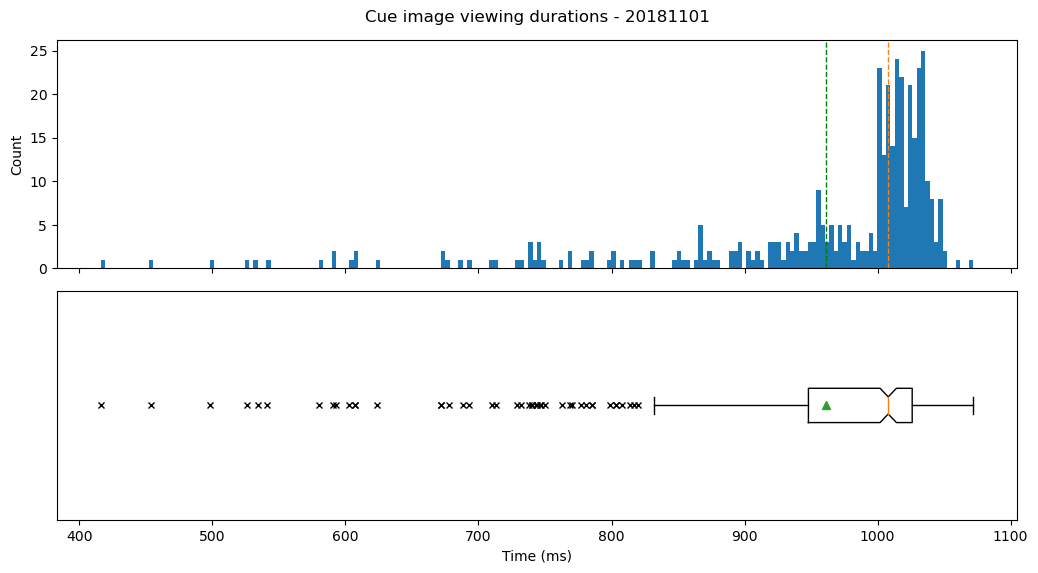

In [43]:
# Distribution of cue phase durations when the cue image was looked at
durs_cue = np.array(list(map(lambda arr: arr.shape[0], timebins_cue)))

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Cue image viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_cue, bins=200)
axes[0].axvline(x=np.mean(durs_cue), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_cue), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_cue, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_cue)

166.32396088029697

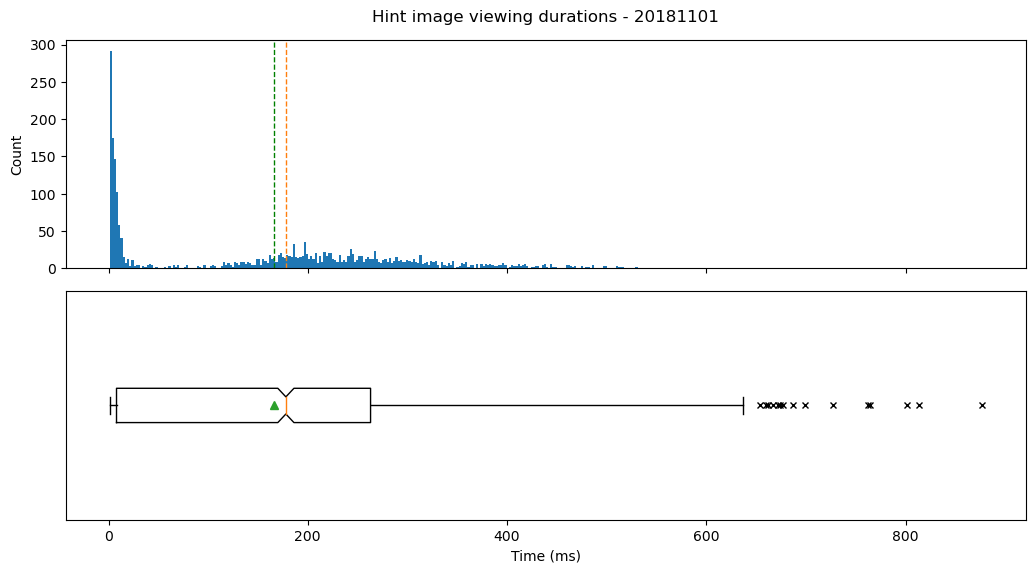

In [44]:
# Distribution of durations when the hint image was looked at
durs_hints = list()
for trial in timebins_hints:
    for obs in trial:
        st_time, ed_time = obs
        durs_hints.append(1000*(ed_time-st_time))
durs_hints = np.array(durs_hints)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Hint image viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_hints, bins=400)
axes[0].axvline(x=np.mean(durs_hints), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_hints), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_hints, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_hints)

960.4141414141415

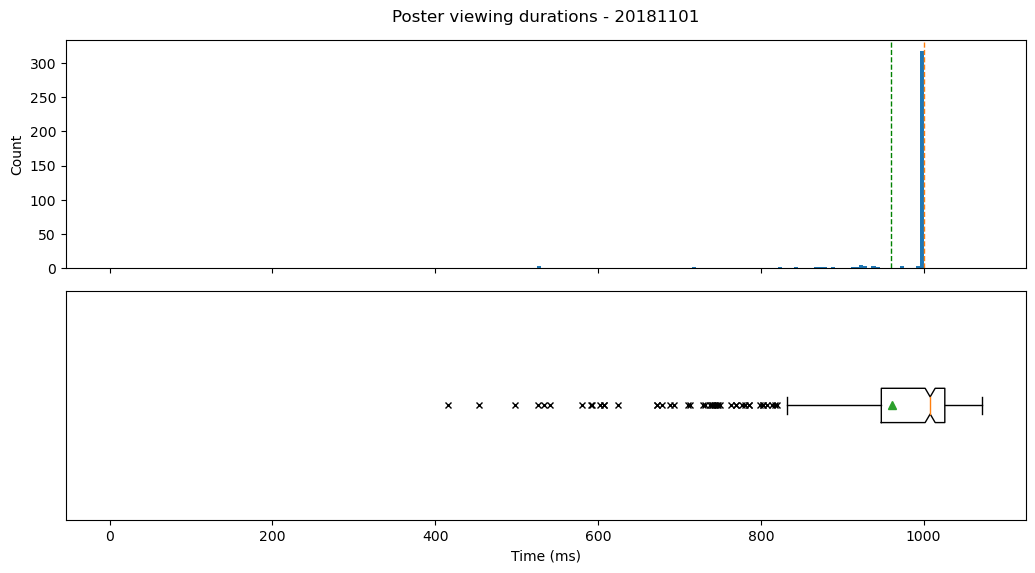

In [45]:
# Distribution of nav end durations when the poster was looked at
durs_navend = np.array(list(map(lambda arr: arr.shape[0], timebins_navend)))

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Poster viewing durations - {day_dir}', y=0.95)

axes[0].hist(durs_navend, bins=200)
axes[0].axvline(x=np.mean(durs_navend), color='green', linewidth=1, linestyle='--')
axes[0].axvline(x=np.median(durs_navend), color='C1', linewidth=1, linestyle='--')
axes[0].set_ylabel('Count')

axes[1].boxplot(durs_cue, showmeans=True, notch=True, vert=False, flierprops={'marker': 'x', 'markersize': 4})
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks([])

np.mean(durs_navend)

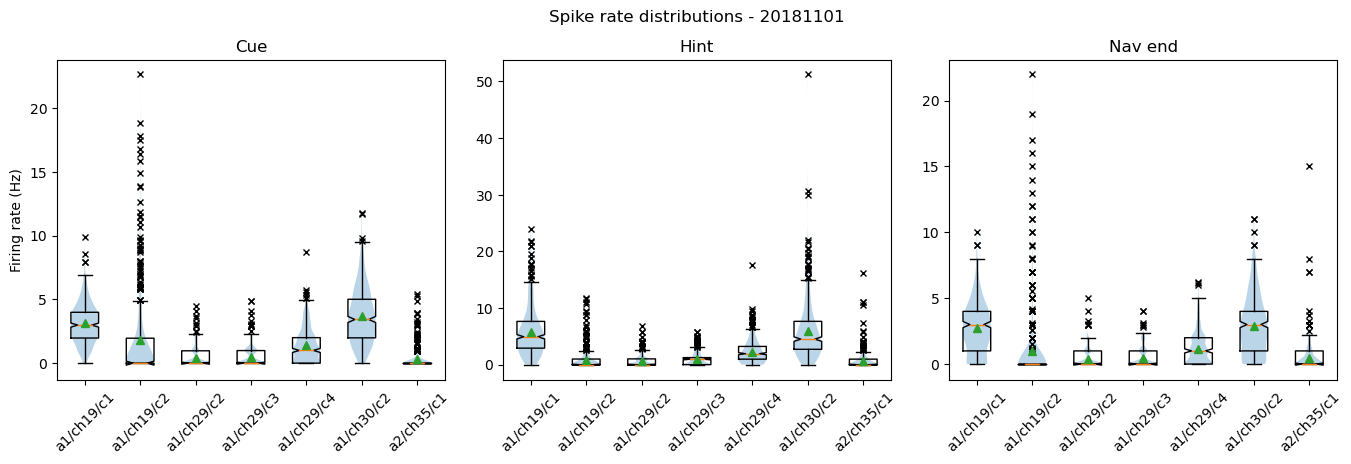

In [46]:
# Distribution of cue/hint/navend phase spike rates
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Spike rate distributions - {day_dir}', y=1.025)

axes[0].set_title('Cue')
axes[0].boxplot(spikerates_cue, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[0].violinplot(spikerates_cue, showextrema=False)
axes[0].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)
axes[0].set_ylabel('Firing rate (Hz)')

axes[1].set_title('Hint')
axes[1].boxplot(spikerates_hints, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[1].violinplot(spikerates_hints, showextrema=False)
axes[1].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)

axes[2].set_title('Nav end')
axes[2].boxplot(spikerates_navend, showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
axes[2].violinplot(spikerates_navend, showextrema=False)
axes[2].set_xticks(np.arange(1, num_cells+1), labels=cell_labels, rotation=45)

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/firingrate_dist.png', bbox_inches='tight')

### Cue phase, goal response distances

In [47]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    # num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

def group_by_trajectory(timeseries: np.array, trajectories: np.array) -> list:
    # num_goals = 6
    grouped = {(i+1, j+1): np.empty((0, timeseries.shape[1])) for j in range(num_goals) for i in range(num_goals) if i != j}
    for idx, traj in enumerate(trajectories):
        goal1, goal2 = int(traj[0]), int(traj[1])
        if goal1 == 0:
            continue
        grouped[(goal1, goal2)] = np.vstack([grouped[(goal1, goal2)], timeseries[idx,:]])
    return grouped

def euclidean_distance(arr1: np.array, arr2: np.array) -> float:
    return np.linalg.norm(arr1 - arr2)

def cosine_similarity(arr1: np.array, arr2: np.array) -> float:
    return np.nansum(np.multiply(arr1, arr2)) / (np.sqrt(np.nansum(np.multiply(arr1, arr1))) * np.sqrt(np.nansum(np.multiply(arr2, arr2))))

def pairwise_distances_between(clust1: np.array, clust2: np.array, metric=euclidean_distance) -> np.array:
    res = list()
    for obs1 in clust1:
        for obs2 in clust2:
            res.append(metric(obs1, obs2))
    return np.array(res)

def pairwise_distances_within(clust: np.array, metric=euclidean_distance) -> np.array:
    res = list()
    for i in range(clust.shape[0] - 1):
        for j in range(i+1, clust.shape[0]):
            obs1, obs2 = clust[i,:], clust[j,:]
            res.append(metric(obs1, obs2))
    return np.array(res)

def cohen_d(sample1: np.array, sample2: np.array) -> float:
    x1, x2 = np.mean(sample1), np.mean(sample2)
    s1, s2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    n1, n2 = sample1.shape[0], sample2.shape[0]
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return (x1 - x2) / s_pooled

In [48]:
# Group cue phase responses according to goal
spikerates_cue_per_goal = group_by_goal(spikerates_cue, goals_cue)

# Create 2D list to store results of all pairwise distances between goals
pairwise_distances_goal = [[np.array([]) for _ in range(num_goals)] for _ in range(num_goals)]
mean_distances_goal = np.empty((num_goals, num_goals))
for i in range(num_goals):
    for j in range(i, num_goals):
        group1, group2 = spikerates_cue_per_goal[i], spikerates_cue_per_goal[j]
        if i == j:
            distances = pairwise_distances_within(group1)
            pairwise_distances_goal[i][i] = distances
            mean_distances_goal[i,i] = np.mean(distances)
        else:
            distances = pairwise_distances_between(group1, group2)
            pairwise_distances_goal[i][j] = distances
            pairwise_distances_goal[j][i] = pairwise_distances_goal[i][j]
            mean_distances_goal[i,j] = np.mean(distances)
            mean_distances_goal[j,i] = mean_distances_goal[i,j]

# Peform Wilcoxon signrank tests to check for significant differences between distance distributions of each goal
# and compute effect sizes of differences between distance distributions of each goal
test_stats, p_vals, fx_sizes = np.empty((num_goals, num_goals)), np.empty((num_goals, num_goals)), np.empty((num_goals, num_goals))
for goal1 in range(num_goals):
    for goal2 in range(num_goals):
        if goal2 == goal1:
            test_stats[goal1][goal2] = np.nan
            p_vals[goal1][goal2] = np.nan
            fx_sizes[goal1][goal2] = np.nan
            continue

        test_stat, p_val = stats.mannwhitneyu(pairwise_distances_goal[goal1][goal2], pairwise_distances_goal[goal1][goal1])
        fx_size = cohen_d(pairwise_distances_goal[goal1][goal2], pairwise_distances_goal[goal1][goal1])

        test_stats[goal1][goal2] = test_stat
        p_vals[goal1][goal2] = p_val
        fx_sizes[goal1][goal2] = fx_size

In [49]:
# TR pillar goals vs all other goals
goal1, goal2 = 4, 5  # 1-indexed
pillar_TR_pairdists = [pairwise_distances_goal[goal1-1][goal2-1]]
pillar_TR_labels = [(goal1, goal2)]

for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_TR_pairdists.append(pairwise_distances_goal[goal1-1][goal-1])
    pillar_TR_labels.append((goal1, goal))
for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_TR_pairdists.append(pairwise_distances_goal[goal2-1][goal-1])
    pillar_TR_labels.append((goal2, goal))

pillar_TR_meandists = np.array([mean_distances_goal[i-1,j-1] for i, j in pillar_TR_labels])
pillar_TR_tstats, pillar_TR_pvals, pillar_TR_fxs = np.empty_like(pillar_TR_meandists), np.empty_like(pillar_TR_meandists), np.empty_like(pillar_TR_meandists)
pillar_TR_tstats[:], pillar_TR_pvals[:], pillar_TR_fxs[:] = np.nan, np.nan, np.nan
for i, dist in enumerate(pillar_TR_pairdists[1:]):
    test_stat, p_val = stats.ranksums(dist, pillar_TR_pairdists[0])
    fx_size = cohen_d(dist, pillar_TR_pairdists[0])
    pillar_TR_tstats[i+1] = test_stat
    pillar_TR_pvals[i+1] = p_val
    pillar_TR_fxs[i+1] = fx_size


# BL pillar goals vs all other goals
goal1, goal2 = 1, 6  # 1-indexed
pillar_BL_pairdists = [pairwise_distances_goal[goal1-1][goal2-1]]
pillar_BL_labels = [(goal1, goal2)]

for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_BL_pairdists.append(pairwise_distances_goal[goal1-1][goal-1])
    pillar_BL_labels.append((goal1, goal))
for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_BL_pairdists.append(pairwise_distances_goal[goal2-1][goal-1])
    pillar_BL_labels.append((goal2, goal))

pillar_BL_meandists = np.array([mean_distances_goal[i-1,j-1] for i, j in pillar_BL_labels])
pillar_BL_tstats, pillar_BL_pvals, pillar_BL_fxs = np.empty_like(pillar_BL_meandists), np.empty_like(pillar_BL_meandists), np.empty_like(pillar_BL_meandists)
pillar_BL_tstats[:], pillar_BL_pvals[:], pillar_BL_fxs[:] = np.nan, np.nan, np.nan
for i, dist in enumerate(pillar_BL_pairdists[1:]):
    test_stat, p_val = stats.ranksums(dist, pillar_BL_pairdists[0])
    fx_size = cohen_d(dist, pillar_BL_pairdists[0])
    pillar_BL_tstats[i+1] = test_stat
    pillar_BL_pvals[i+1] = p_val
    pillar_BL_fxs[i+1] = fx_size

In [64]:
# Apply PCA to cue phase spike rates for subsequent visualization
# For scree plot/cumulative explained variance
pca = PCA()
pca.fit(spikerates_cue)
pca_numcomps, pca_expvar = pca.n_components_, pca.explained_variance_ratio_

# For actual fitting to data, using 3 PCs
pca = PCA(n_components=3)
pcspikerates_cue = pca.fit_transform(spikerates_cue)

# Group cue phase responses according to goal
pcspikerates_cue_per_goal = group_by_goal(pcspikerates_cue, goals_cue)

# Group cue phase responses according to trajectory
# pcspikerates_cue_per_traj = group_by_trajectory(pcspikerates_cue, trajectories_cue)

# Group cue phase responses according to trajectory, then group by same start goal and same end goal
spikerates_cue_per_traj = group_by_trajectory(spikerates_cue, trajectories_cue)
spikerates_cue_start_goals, spikerates_cue_end_goals = [np.empty((0, num_cells)) for _ in range(num_goals)], [np.empty((0, num_cells)) for _ in range(num_goals)]
start_goals_labels, end_goals_labels = [list() for _ in range(num_goals)], [list() for _ in range(num_goals)]
for traj, responses in spikerates_cue_per_traj.items():
    start_goal, end_goal = traj[0] - 1, traj[1] - 1
    spikerates_cue_start_goals[start_goal] = np.vstack([spikerates_cue_start_goals[start_goal], responses])
    start_goals_labels[start_goal].extend(responses.shape[0] * [end_goal + 1])
    spikerates_cue_end_goals[end_goal] = np.vstack([spikerates_cue_end_goals[end_goal], responses])
    end_goals_labels[end_goal].extend(responses.shape[0] * [start_goal + 1])

# Fit PCA within each group of same starting/same ending goal
pcspikerates_cue_start_goals, pcspikerates_cue_end_goals = list(), list()
for i in range(num_goals):
    pcspikerates_cue_start_goals.append(pca.fit_transform(spikerates_cue_start_goals[i]))
    pcspikerates_cue_end_goals.append(pca.fit_transform(spikerates_cue_end_goals[i]))

# Regroup into trajectories for plotting
pcspikerates_cue_per_traj = [[np.empty((0, 3)) for i in range(num_goals)] for j in range(num_goals)]
for i in range(num_goals):
    for j, data in enumerate(pcspikerates_cue_start_goals[i]):
        k = start_goals_labels[i][j] - 1
        pcspikerates_cue_per_traj[i][k] = np.concatenate([pcspikerates_cue_per_traj[i][k], data.reshape(-1, 3)], axis=0)

Plots for response distances

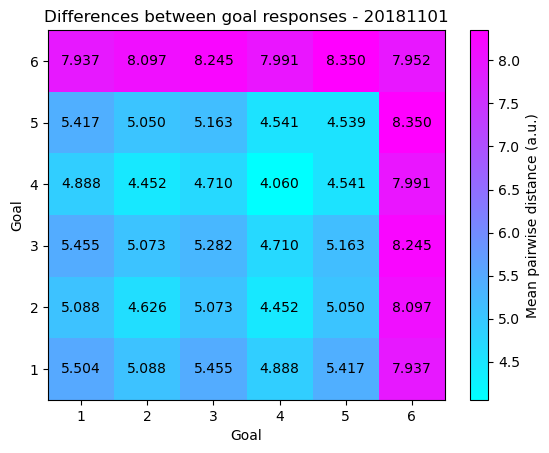

In [51]:
# Plot heatmap of mean distances
plt.figure()
ax = plt.gca()
plt.title(f'Differences between goal responses - {day_dir}')
plt.pcolormesh(mean_distances_goal, cmap='cool')
plt.colorbar(label='Mean pairwise distance (a.u.)')
plt.xticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.xlabel('Goal')
plt.ylabel('Goal')
for i, row in enumerate(mean_distances_goal):
    for j, val in enumerate(row):
        ax.text(j+0.5, i+0.5, f'{val:.3f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/distances_heatmap.png', bbox_inches='tight')

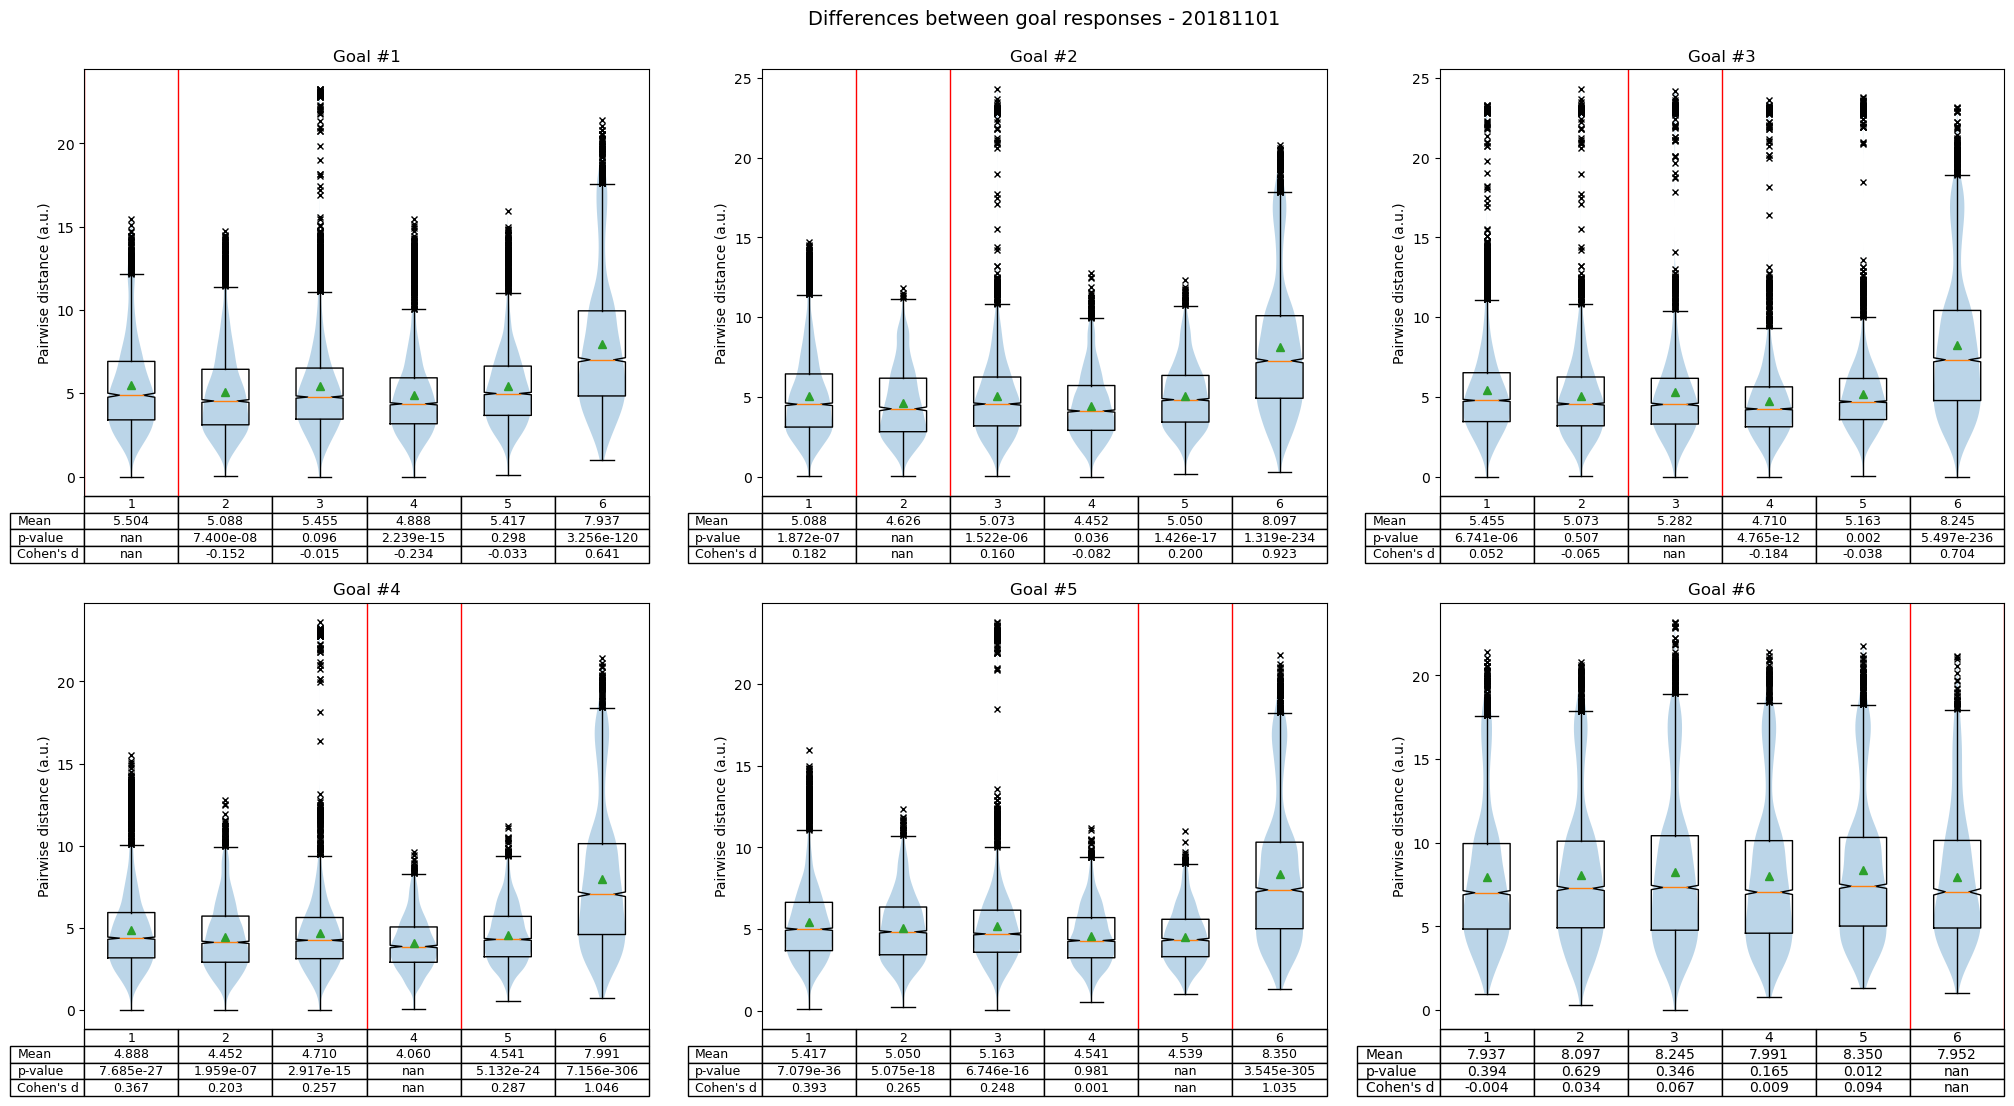

In [52]:
# Plot boxplot distribution of distances between one goal and the rest for all goals
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.25)
plt.suptitle(f'Differences between goal responses - {day_dir}', fontsize=14, y=0.95)

for goal in range(num_goals):
    ax = axes[goal//3, goal%3]
    ax.set_title(f'Goal #{goal+1}')
    ax.boxplot(pairwise_distances_goal[goal], showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
    ax.violinplot(pairwise_distances_goal[goal], showextrema=False)
    ax.table(cellText=[[f'{val:.3f}' for val in mean_distances_goal[goal,:]], [f'{val:.3f}' if val >= 1e-3 else f'{val:.3e}' for val in p_vals[goal,:]], \
                       [f'{val:.3f}' for val in fx_sizes[goal,:]]], rowLabels=['Mean', 'p-value', 'Cohen\'s d'], colLabels=list(range(1, num_goals+1)), cellLoc='center')
    ax.axvline(x=goal+0.5, color='r', linewidth=1)
    ax.axvline(x=goal+1.5, color='r', linewidth=1)
    ax.set_xticks([])
    ax.set_ylabel('Pairwise distance (a.u.)')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/distances_barplots.png', bbox_inches='tight')

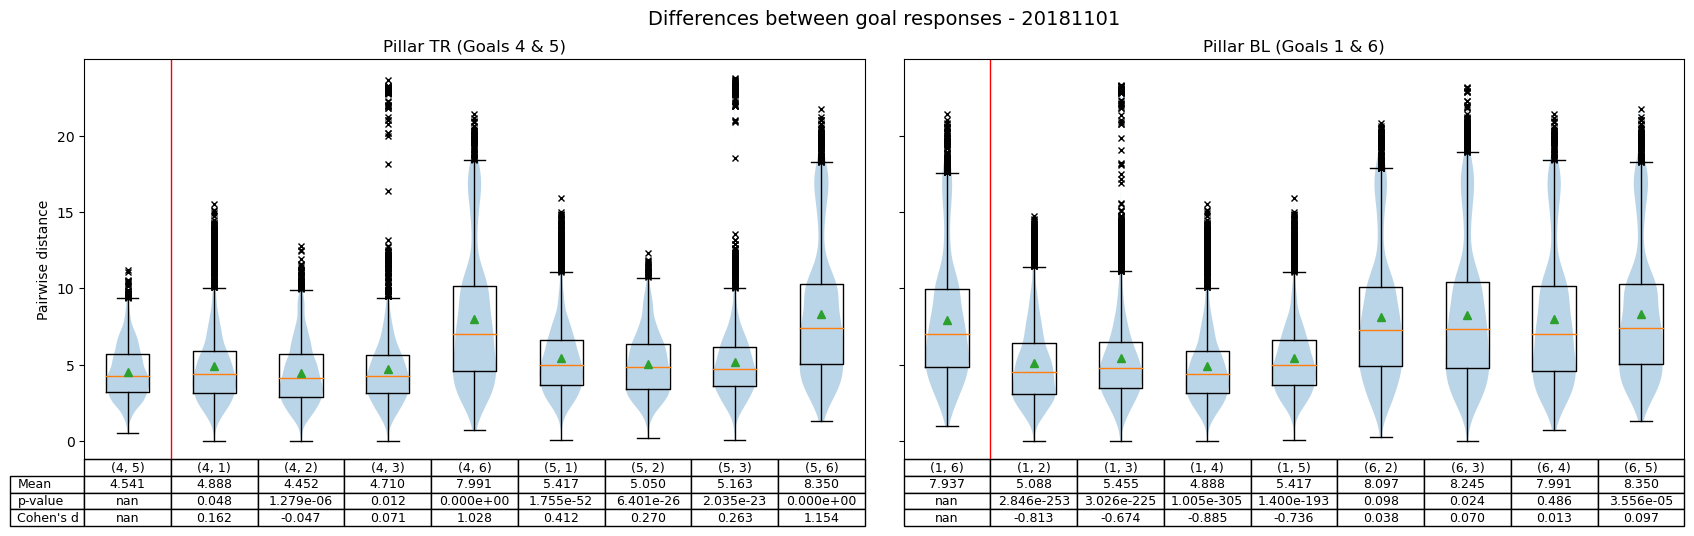

In [53]:
# Plot pairwise distance distributions between goals on TR/BL pillar and the rest
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.1)
plt.suptitle(f'Differences between goal responses - {day_dir}', fontsize=14, y=1)

axes[0].set_title('Pillar TR (Goals 4 & 5)')
axes[0].boxplot(pillar_TR_pairdists, showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
axes[0].violinplot(pillar_TR_pairdists, showextrema=False)
axes[0].axvline(x=1.5, color='r', linewidth=1)
axes[0].table(cellText=[[f'{val:.3f}' for val in pillar_TR_meandists], [f'{val:.3f}' if val >= 1e-3 else f'{val:.3e}' for val in pillar_TR_pvals], \
                       [f'{val:.3f}' for val in pillar_TR_fxs]], rowLabels=['Mean', 'p-value', 'Cohen\'s d'], colLabels=pillar_TR_labels, cellLoc='center')
axes[0].set_xticks([])
axes[0].set_ylabel('Pairwise distance')

axes[1].set_title('Pillar BL (Goals 1 & 6)')
axes[1].boxplot(pillar_BL_pairdists, showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
axes[1].violinplot(pillar_BL_pairdists, showextrema=False)
axes[1].axvline(x=1.5, color='r', linewidth=1)
axes[1].table(cellText=[[f'{val:.3f}' for val in pillar_BL_meandists], [f'{val:.3f}' if val >= 1e-3 else f'{val:.3e}' for val in pillar_BL_pvals], \
                       [f'{val:.3f}' for val in pillar_BL_fxs]], colLabels=pillar_BL_labels, cellLoc='center')
axes[1].set_xticks([])

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/distances_barplots_pillars.png', bbox_inches='tight')

Text(0, 0.5, '% Variance Explained')

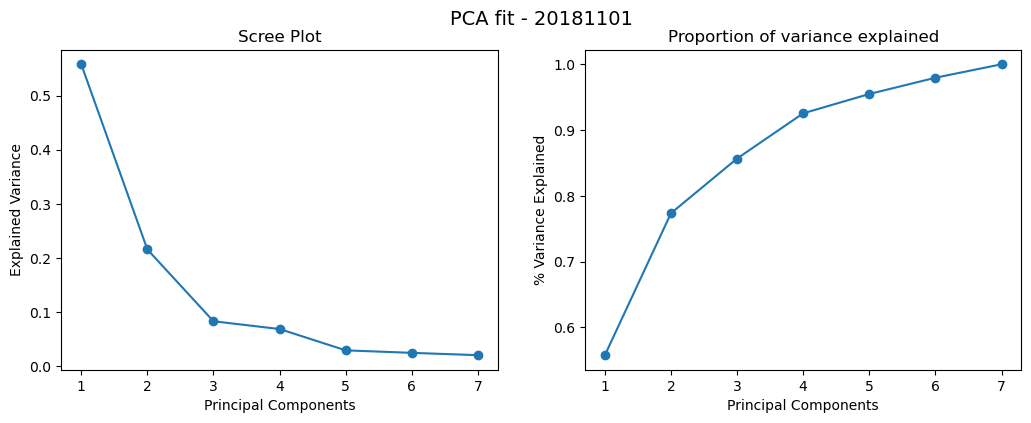

In [54]:
# PCA scree plot and cumulative explained variance for cue spike rates
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.1)
plt.suptitle(f'PCA fit - {day_dir}', fontsize=14, y=1)

axes[0].set_title('Scree Plot')
axes[0].plot(np.arange(pca_numcomps), pca_expvar, 'o-')
axes[0].set_xticks(np.arange(pca_numcomps), labels=np.arange(1, pca_numcomps+1))
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance')

axes[1].set_title('Proportion of variance explained')
axes[1].plot(np.arange(pca_numcomps), np.cumsum(pca_expvar), 'o-')
axes[1].set_xticks(np.arange(pca_numcomps), labels=np.arange(1, pca_numcomps+1))
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('% Variance Explained')

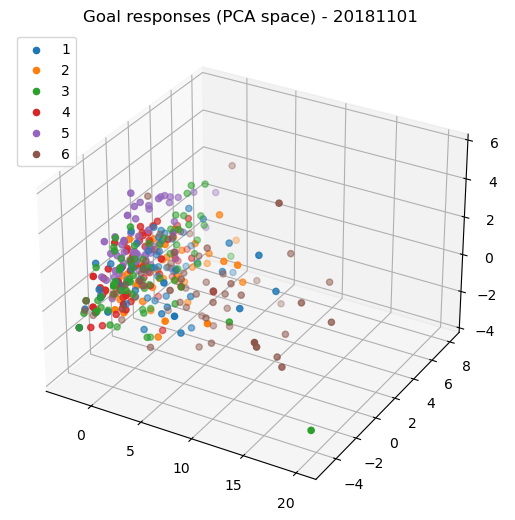

In [55]:
# Plot in PCA space for cue responses between different goals
fig = plt.figure()
ax = fig.gca()
ax.axis('off')
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
plt.title(f'Goal responses (PCA space) - {day_dir}')
for i in range(num_goals):
    plot_data = pcspikerates_cue_per_goal[i]
    ax.scatter(plot_data[:,0], plot_data[:,1], plot_data[:,2], color=f'C{i}', label=i+1)
plt.legend(loc='upper left')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/responses_pca_all.png', bbox_inches='tight')

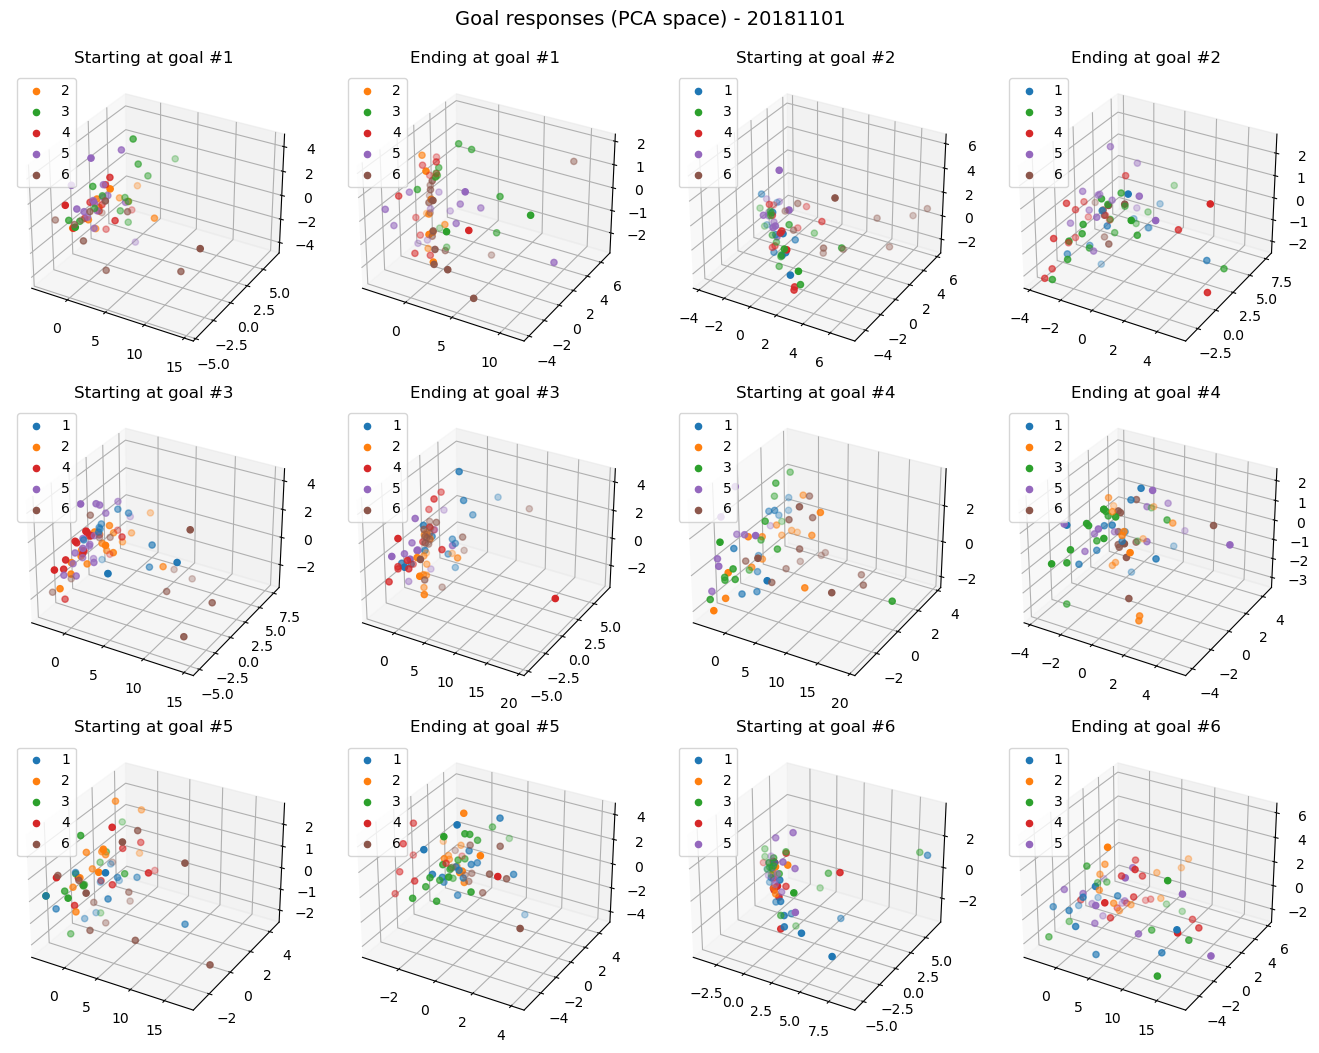

In [65]:
# Plots in PCA space for cue responses between different trajectories
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15, hspace=0.15)
plt.suptitle(f'Goal responses (PCA space) - {day_dir}', fontsize=14, y=0.95)

'''
for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    plot_data, plot_labels = list(), list()
    for traj, responses in pcspikerates_cue_per_traj.items():
        if traj[0] == i+1:
            plot_data.append(responses)
            plot_labels.append(traj[1])
    for j, data in enumerate(plot_data):
        ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{plot_labels[j]-1}', label=plot_labels[j])
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    plot_data, plot_labels = list(), list()
    for traj, responses in pcspikerates_cue_per_traj.items():
        if traj[1] == i+1:
            plot_data.append(responses)
            plot_labels.append(traj[0])
    for j, data in enumerate(plot_data):
        ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{plot_labels[j]-1}', label=plot_labels[j])
    ax.legend(loc='upper left')
'''

for i in range(num_goals):
    ax = fig.add_subplot(3, 4, 2*i+1, projection='3d')
    ax.set_title(f'Starting at goal #{i+1}')
    for j, data in enumerate(pcspikerates_cue_per_traj[i]):
        if data.shape[0] > 0:
            ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{j}', label=j+1)
    ax.legend(loc='upper left')

    ax = fig.add_subplot(3, 4, 2*i+2, projection='3d')
    ax.set_title(f'Ending at goal #{i+1}')
    for j in range(num_goals):
        data = pcspikerates_cue_per_traj[j][i]
        if data.shape[0] > 0:
            ax.scatter(data[:,0], data[:,1], data[:,2], color=f'C{j}', label=j+1)
    ax.legend(loc='upper left')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/responses_pca_trajectories.png', bbox_inches='tight')

### Cue/Hint/Navend phase, goal response decoding

In [57]:
class ResponseClassifier():
    def __init__(self, model):
        self.model = model

    def fit(self, X, y, thresh):
        self.model.fit(X, y)
        self.thresh = thresh

    def set_thresh(self, thresh):
        self.thresh = thresh

    def predict(self, X):
        classes = self.model.predict(X)
        probs = self.model.predict_proba(X)
        filt = np.where(np.max(probs, axis=1) < self.thresh)
        classes[filt] = 0
        return classes


def train_test_split(X: np.array, y: np.array, split: tuple) -> tuple:
    # itr: current iteration of k-fold validation
    # way: value of k in k-fold validation
    itr, way = split
    X_train, X_test = list(), list()
    y_train, y_test = list(), list()
    for num, obs in enumerate(X):
        if num % way == itr:
            X_test.append(obs)
            y_test.append(y[num])
        else:
            X_train.append(obs)
            y_train.append(y[num])
    # Return format: X_train, X_test, y_train, y_test   
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def confusion_matrix(y_pred: np.array, y_actl: np.array, num_classes: int) -> np.array:
    res = np.zeros((num_classes, num_classes), dtype=int)
    for pred, actl in zip(y_pred, y_actl):
        pred, actl = int(pred - 1), int(actl - 1)
        res[pred, actl] += 1
    return res

def prediction_accuracy(y_pred: np.array, y_actl: np.array) -> float:
    count, total = 0, y_actl.shape[0]
    for num, obs in enumerate(y_pred):
        if obs == y_actl[num]:
            count += 1
    return count / total

In [58]:
# Build decoder for 6+1 classes
k_fold = 10
prob_mins = np.zeros(k_fold)
accuracy_cue = np.zeros(k_fold)
confusion_cue = np.zeros((num_goals, num_goals))
models = list()
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikerates_cue, goals_cue, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_train)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    prob_mins[i] = np.min(y_pred_proba)
    accuracy_cue[i] = prediction_accuracy(y_pred, y_test)
    confusion_cue += confusion_matrix(y_pred, y_test, num_goals)
    models.append(lda)

prob_thresh = np.mean(prob_mins)
print(prob_thresh)

0.2101034171559532


In [59]:
# Fit models using each fold of data
confusion_hints, confusion_navend = np.zeros((num_goals+1, num_goals+1)), np.zeros((num_goals+1, num_goals+1))
accuracy_hints, accuracy_navend = np.zeros(k_fold), np.zeros(k_fold)

for i, model in enumerate(models):
    models[i] = ResponseClassifier(model)
    models[i].set_thresh(prob_mins[i])

    # Prediction on hint viewing phases
    hints_preds = model.predict(spikerates_hints)
    confusion_hints += confusion_matrix(hints_preds, goals_hints, num_goals+1)
    accuracy_hints[i] = prediction_accuracy(hints_preds, goals_hints)

    # Prediction on navend phases
    navend_preds = model.predict(spikerates_navend)
    confusion_navend += confusion_matrix(navend_preds, goals_navend, num_goals+1)
    accuracy_navend[i] = prediction_accuracy(navend_preds, goals_navend)

Plots for decoding

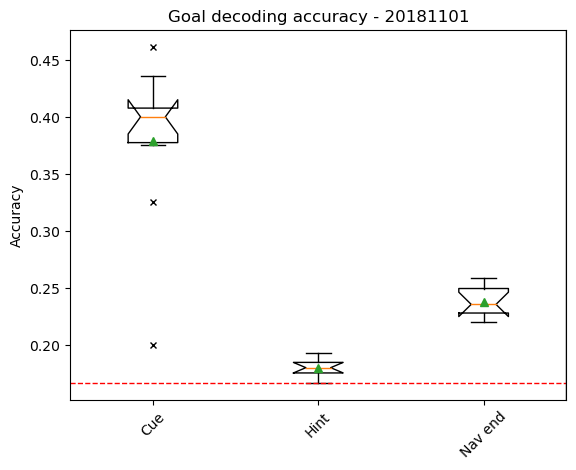

In [60]:
# Plot variance in prediciton accuracy between datasets
accuracies = {'Cue': accuracy_cue, 'Hint': accuracy_hints, 'Nav end': accuracy_navend}

plt.figure()
plt.title(f'Goal decoding accuracy - {day_dir}')
plt.boxplot(accuracies.values(), showmeans=True, notch=True, flierprops={'marker': 'x', 'markersize': 4})
# plt.violinplot(accuracies.values(), showextrema=False)
plt.axhline(y=1/6, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 4), labels=accuracies.keys(), rotation=45)
plt.ylabel('Accuracy')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/decoding_accuracy.png', bbox_inches='tight')

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_59533/3144593387.py:13: RuntimeWarning: invalid value encountered in true_divide
  conf_mat_prop[:,col] = conf_mat[:,col] / val


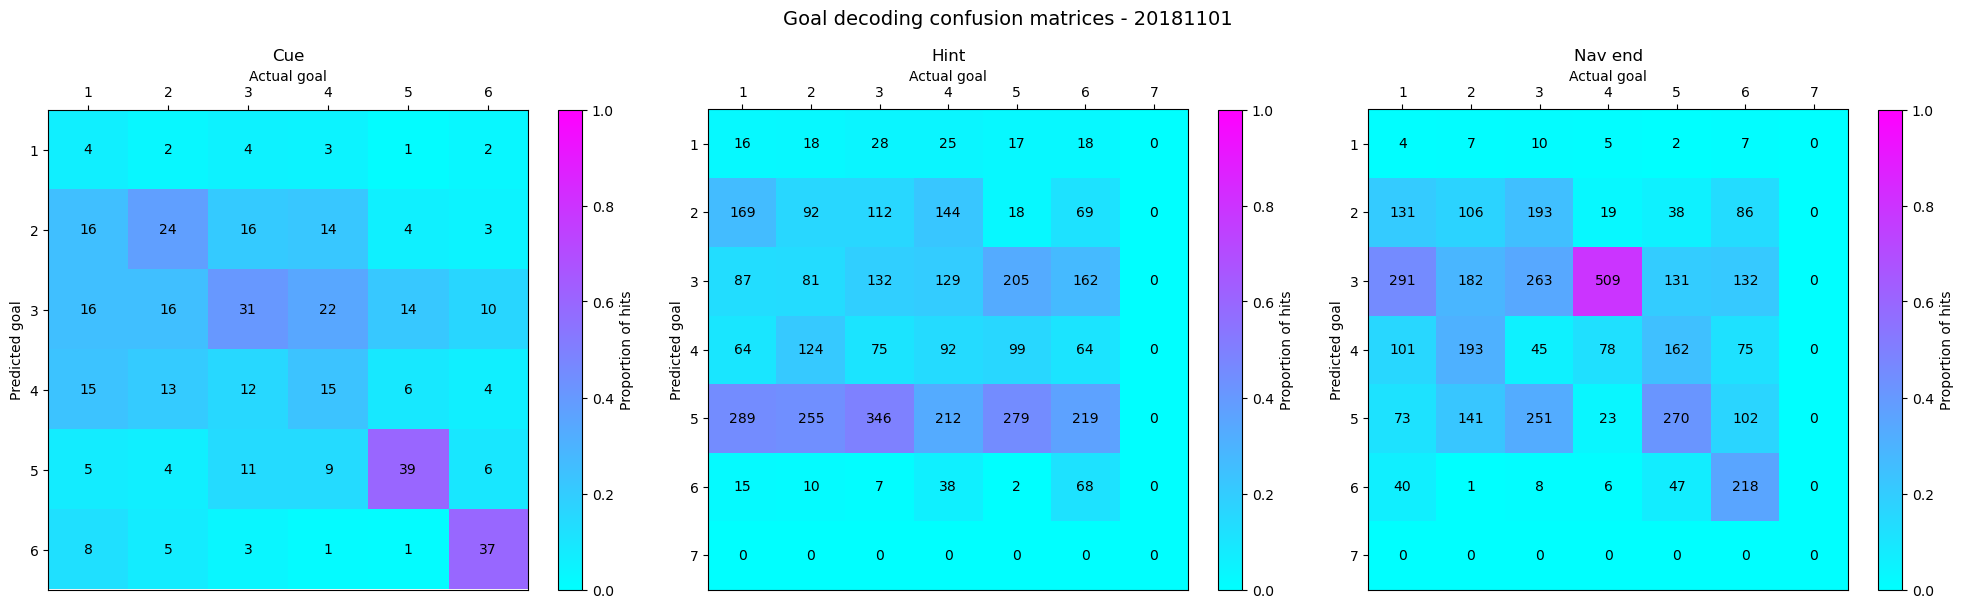

In [61]:
# Plot confusion matrices for cue, hint and nav end in a single plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.suptitle(f'Goal decoding confusion matrices - {day_dir}', fontsize=14, y=0.925)
confusion_matrices = {'Cue': confusion_cue, 'Hint': confusion_hints, 'Nav end': confusion_navend}

for i, entry in enumerate(confusion_matrices.items()):
    label, conf_mat = entry
    num_cats = conf_mat.shape[0]
    col_sums = np.sum(conf_mat, axis=0)
    conf_mat_prop = np.empty_like(conf_mat)
    for col, val in enumerate(col_sums):
        conf_mat_prop[:,col] = conf_mat[:,col] / val
    conf_mat_prop = np.nan_to_num(conf_mat_prop)

    ax = axes[i]
    ax.set_title(label)
    im = ax.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, label='Proportion of hits', shrink=0.75)

    class_labels = list(range(1, num_cats+1))
    if len(class_labels) > num_goals:
        class_labels.pop()
        class_labels.append('None')
    ax.set_xticks(np.arange(num_cats), labels=class_labels)
    ax.set_yticks(np.arange(num_cats), labels=class_labels)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xlabel('Actual goal')
    ax.set_ylabel('Predicted goal')
    ax.xaxis.set_label_position('top')

    for i, row in enumerate(conf_mat):
        for j, val in enumerate(row):
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

if not os.path.exists(figsave_dir):
    os.makedirs(figsave_dir)
plt.savefig(f'{figsave_dir}/decoding_confusion.png', bbox_inches='tight')

### Save results to pkl file

In [62]:
# Package variables by analysis
raw_data = {'spikerates_cue': spikerates_cue, 'spikerates_hints': spikerates_hints, 'spikerates_navend': spikerates_navend,\
            'goals_cue': goals_cue, 'goals_hints': goals_hints, 'goals_navend': goals_navend,\
            'trajectories_cue': trajectories_cue, 'trajectories_hints': trajectories_hints, 'trajectories_navend': trajectories_navend}
goal_distances = {'pairwise_distances_goal': pairwise_distances_goal, 'mean_distances_goal': mean_distances_goal,\
                  'pcspikerates_cue_per_goal': pcspikerates_cue_per_goal, 'pcspikerates_cue_per_traj': pcspikerates_cue_per_traj,\
                  'test_stats': test_stats, 'p_vals': p_vals, 'fx_sizes': fx_sizes}
goal_decoding = {'models': models, 'accuracies': accuracies, 'confusion_matrices': confusion_matrices}
data = {'raw_data': raw_data, 'goal_distances': goal_distances, 'goal_decoding': goal_decoding}

# Save to pickle file
if not os.path.exists(datasave_dir):
    os.makedirs(datasave_dir)
with open(f'{datasave_dir}/{day_dir}_data.pkl', 'wb') as file:
    pickle.dump(data, file)